# Deep Learning with PyTorch : Build a Generative Adversarial Network

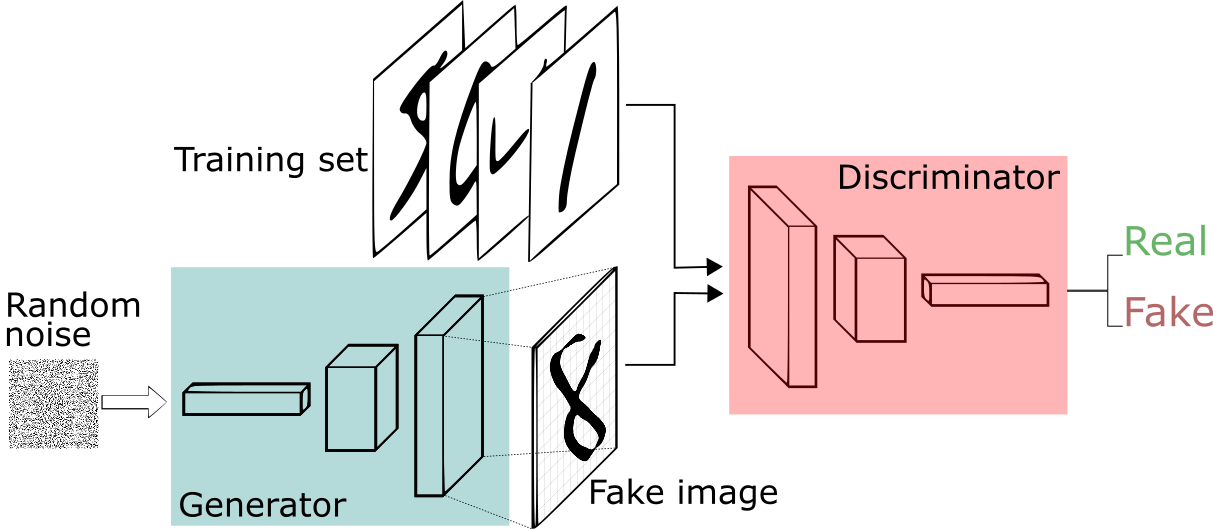

In [ ]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Configurations

In [ ]:
device =  'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 128
noise_dim = 64

# Optimizer s Parameters
lr = 0.002
beta_1 = 0.5
beta_2 = 0.99

# Training variables
epochs = 20


# Load MNIST Dataset

In [ ]:
from torchvision import datasets, transforms as T

In [ ]:
train_augs = T.Compose([
    T.RandomRotation((-20, +20)),
    T.ToTensor()
])

In [ ]:
trainset = datasets.MNIST(root = 'MNIST/', train = True, download = True, transform = train_augs)

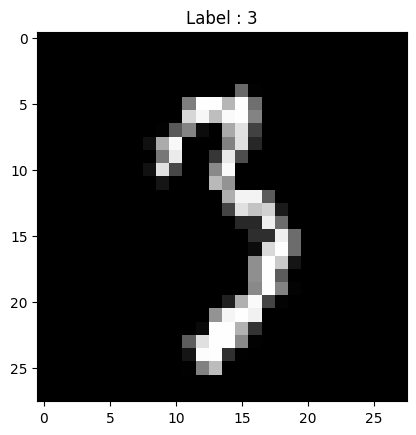

In [ ]:
idx = np.random.randint(0, len(trainset))
image, label = trainset[idx]
plt.imshow(image.squeeze(), cmap = 'gray')
plt.title(f'Label : {label}')
plt.show()

In [ ]:
print(f'Number of images in trainset : {len(trainset)}')

Number of images in trainset : 60000


# Load Dataset Into Batches

In [ ]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [ ]:
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)

In [ ]:
print(f'Number of batches in trainloader : {len(trainloader)}')

Number of batches in trainloader : 469


In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter) # Use next(dataiter) instead of dataiter.next()
print(images.shape)

torch.Size([128, 1, 28, 28])


In [ ]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

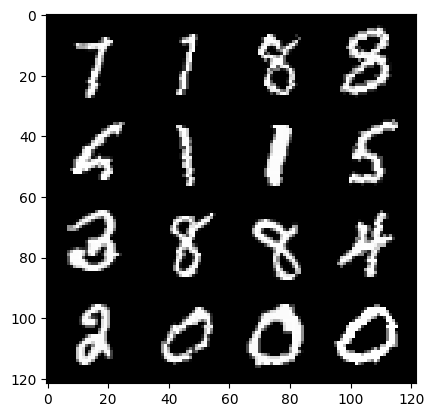

In [ ]:
show_tensor_images(images)

# Create Discriminator Network

In [ ]:
#In case if torch summary is not installed

!pip install torchsummary

In [ ]:
from torch import nn
from torchsummary import summary

In [ ]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

'\n\nNetwork : Discriminator\n\ninput : (bs, 1, 28, 28)\n      |                                                                                               ---- SUMMARY ----\n      V\nConv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)\nBatchNorm2d()                                                                                          #(bs, 16, 13, 13)\nLeakyReLU()                                                                                            #(bs, 16, 13, 13)\n      |\n      V\nConv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)\nBatchNorm2d()                                                                                          #(bs, 32, 5, 5)\nLeakyReLU()                                                                                            #(bs, 32, 5, 5)\n      |\n      V\nConv2d( in_channels = 32, out_channels = 64, kernel

In [ ]:
def get_disc_block(in_channels, out_channels, kernel_size, stride):
    return nn.Sequential(
        nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, stride = stride),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.block_1 = get_disc_block(in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)
        self.block_2 = get_disc_block(in_channels = 16, out_channels = 32, kernel_size = (5, 5), stride = 2)
        self.block_3 = get_disc_block(in_channels = 32, out_channels = 64, kernel_size = (5, 5), stride = 2)

        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features = 64, out_features = 1)

    def forward(self, images):
        x1 = self.block_1(images)
        x2 = self.block_2(x1)
        x3 = self.block_3(x2)
        x4 = self.flatten(x3)
        x5 = self.linear(x4)
        return x5

In [ ]:
D = Discriminator().to(device)

summary(D, input_size = (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network

In [ ]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

'\n\nNetwork : Generator\n\nz_dim = 64\ninput : (bs,z_dim)\n\n      |\n      | Reshape\n      V\n\ninput : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)\n      |                                                                                               ---- SUMMARY ----\n      V\nConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)\nBatchNorm2d()                                                                                          #(bs, 256, 3, 3)\nReLU()                                                                                                 #(bs, 256, 3, 3)\n      |\n      V\nConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)\nBatchNorm2d()                                                                                          #(bs, 128, 6, 6)\nReLU()                                                                                 

In [ ]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block = False):
    if final_block:
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, stride = stride),
            nn.Tanh()
        )

    return nn.Sequential(
        nn.ConvTranspose2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, stride = stride),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

In [ ]:
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()

        self.noise_dim = noise_dim
        self.block_1 = get_gen_block(noise_dim, 256, (3,3), 2)
        self.block_2 = get_gen_block(256, 128, (4,4), 1)
        self.block_3 = get_gen_block(128, 64, (3,3), 2)
        self.block_4 = get_gen_block(64, 1, (4,4), 2, final_block = True)

    def forward(self, r_noise_vec):
        x = r_noise_vec.view(-1, self.noise_dim, 1, 1)
        x1 = self.block_1(x)
        x2 = self.block_2(x1)
        x3 = self.block_3(x2)
        x4 = self.block_4(x3)
        return x4

In [ ]:
G = Generator(noise_dim = noise_dim).to(device)

summary(G, input_size = (1, noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [ ]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [ ]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [ ]:
def real_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    ground_truth = torch.ones_like(disc_pred)
    loss = criterion(disc_pred, ground_truth)
    return loss

def fake_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    ground_truth = torch.zeros_like(disc_pred)
    loss = criterion(disc_pred, ground_truth)
    return loss

In [ ]:
D_opt = torch.optim.Adam(D.parameters(), lr = lr, betas = (beta_1, beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr = lr, betas = (beta_1, beta_2))

# Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 1/20 | D_loss : 0.6723018681316741 | G_loss : 0.7375888501657352


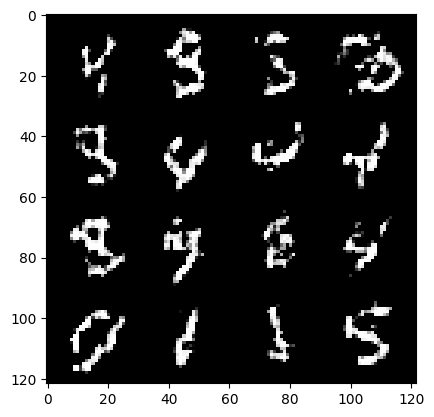

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 2/20 | D_loss : 0.6506144372639118 | G_loss : 0.7912811879664342


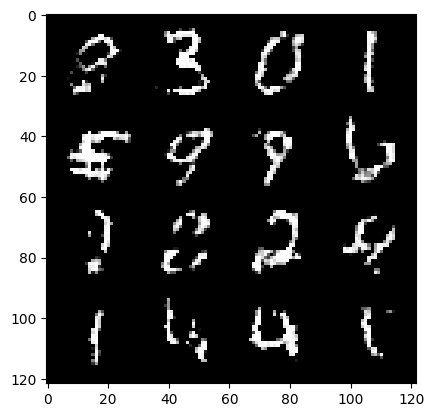

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 3/20 | D_loss : 0.6522956923889452 | G_loss : 0.796618429201244


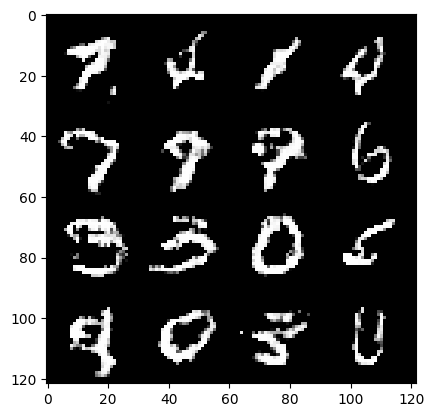

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 4/20 | D_loss : 0.6544110510649204 | G_loss : 0.8001996405851612


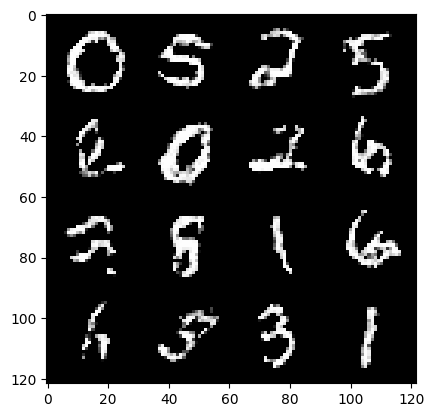

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 5/20 | D_loss : 0.6541558256281464 | G_loss : 0.8025786780090983


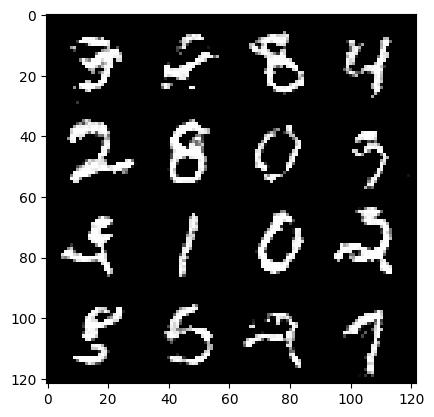

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 6/20 | D_loss : 0.6561674357477282 | G_loss : 0.8003414617672658


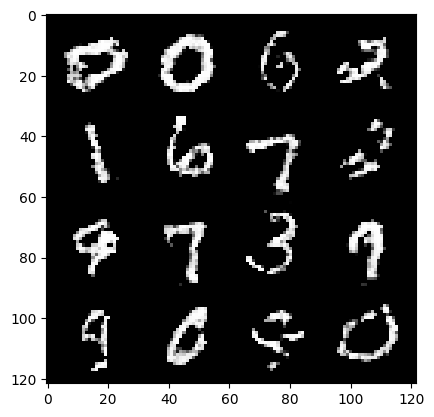

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 7/20 | D_loss : 0.6556074401971373 | G_loss : 0.801409100545749


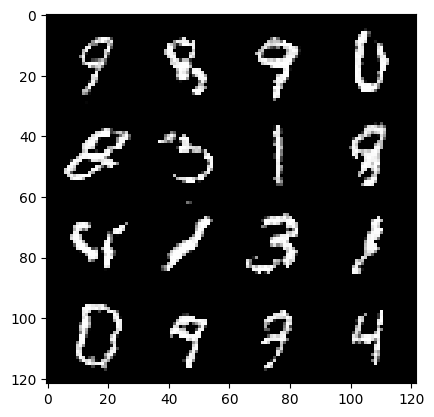

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 8/20 | D_loss : 0.6565048401035479 | G_loss : 0.80436072954491


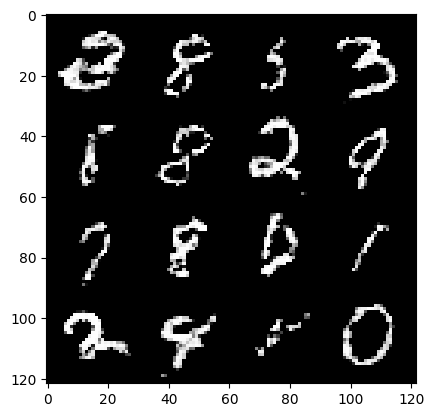

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 9/20 | D_loss : 0.653429457119533 | G_loss : 0.8075294629343028


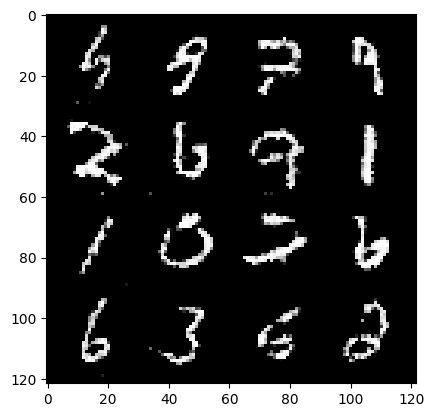

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 10/20 | D_loss : 0.6506345024241059 | G_loss : 0.8172053431651232


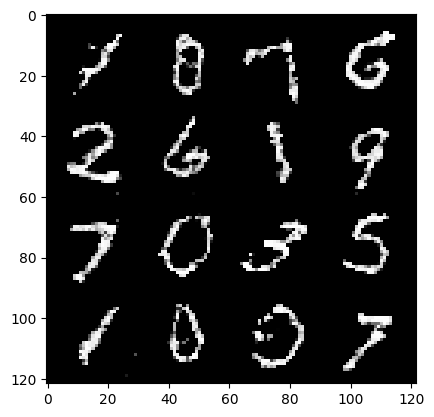

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 11/20 | D_loss : 0.649880416484784 | G_loss : 0.8223790223918744


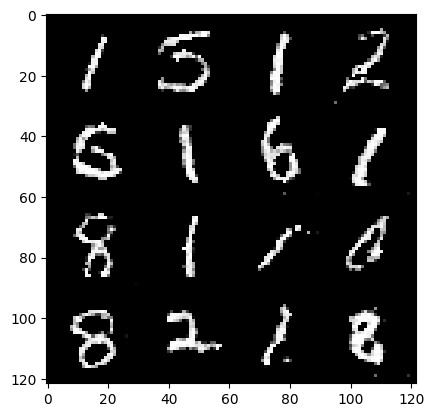

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 12/20 | D_loss : 0.6496254609846103 | G_loss : 0.8207794355431091


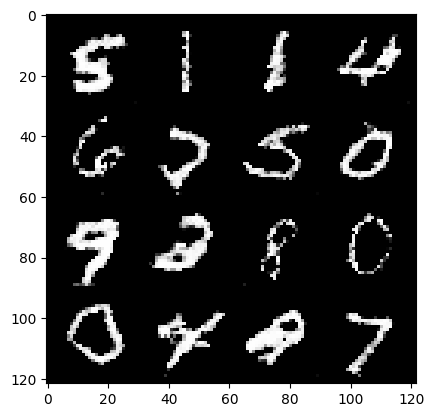

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 13/20 | D_loss : 0.6467695378545505 | G_loss : 0.8312472418935568


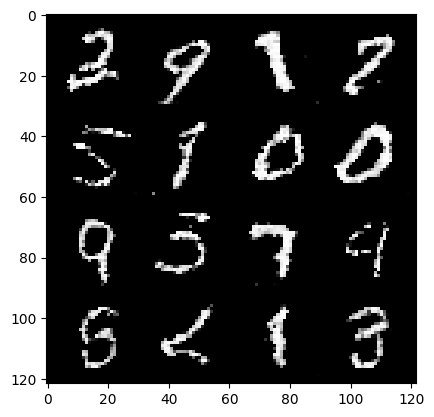

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 14/20 | D_loss : 0.6425603056258993 | G_loss : 0.8416278916381316


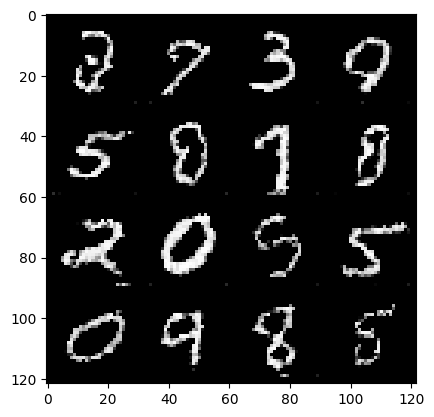

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 15/20 | D_loss : 0.6400192659546826 | G_loss : 0.8496583630281217


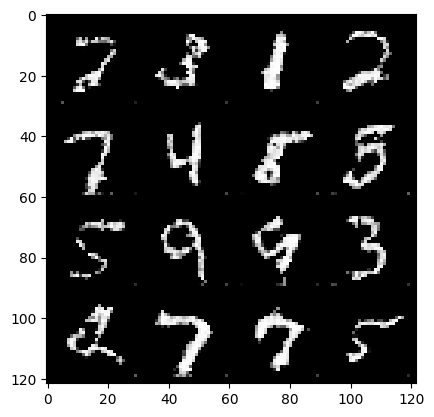

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 16/20 | D_loss : 0.6337206908888908 | G_loss : 0.8635679557125198


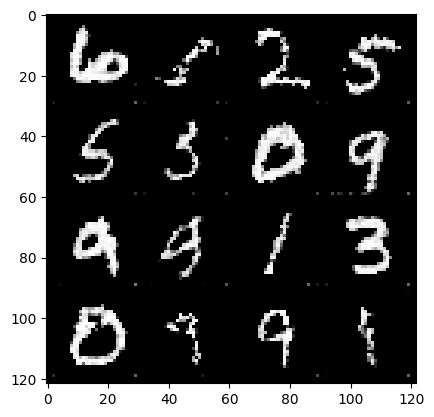

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 17/20 | D_loss : 0.6284201142630343 | G_loss : 0.8781087538326727


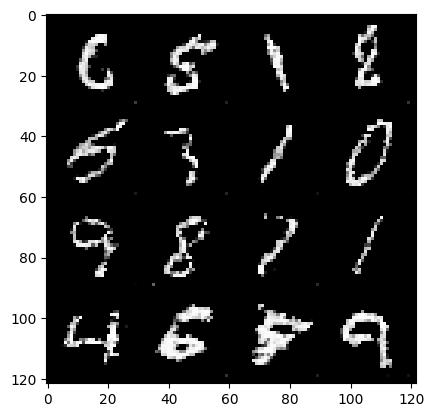

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 18/20 | D_loss : 0.6230040763232754 | G_loss : 0.8976136886997264


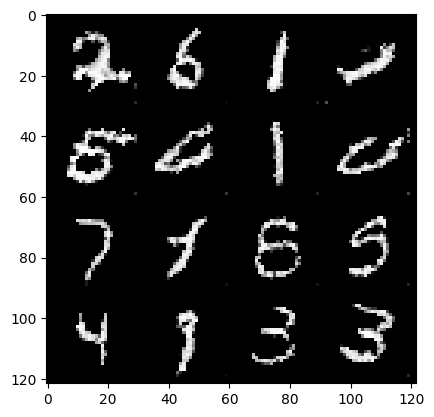

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 19/20 | D_loss : 0.6204626947832006 | G_loss : 0.9048355721207316


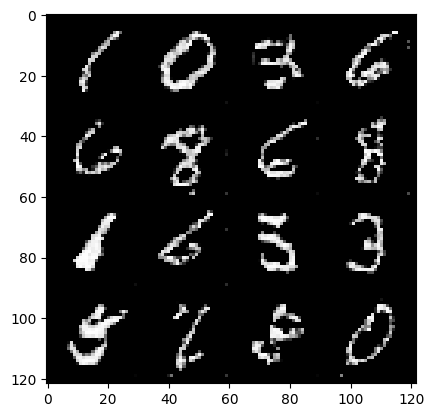

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 20/20 | D_loss : 0.6158348370208415 | G_loss : 0.9168983001444639


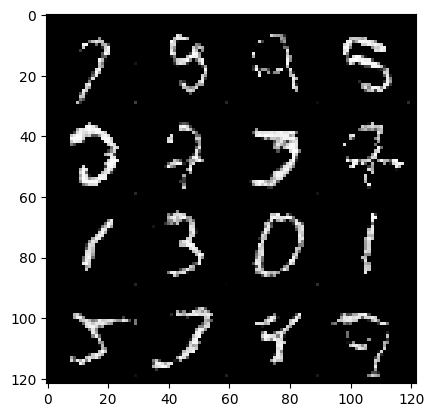

In [ ]:
for i in range(epochs):

    total_d_loss = 0
    total_g_loss = 0

    for real_img, _ in tqdm(trainloader):

        real_img = real_img.to(device)
        noise = torch.randn(batch_size, noise_dim, device = device)

        # Find loss and update weights for D
        D_opt.zero_grad()
        fake_img = G(noise)
        D_pred = D(fake_img)
        D_fake_loss = fake_loss(D_pred)
        D_pred = D(real_img)
        D_real_loss = real_loss(D_pred)
        D_loss = (D_fake_loss + D_real_loss) / 2
        total_d_loss += D_loss.item()
        D_loss.backward()
        D_opt.step()

        # Find loss and update weights for G
        G_opt.zero_grad()
        noise = torch.randn(batch_size, noise_dim, device = device)
        fake_img = G(noise)
        D_pred = D(fake_img)
        G_loss = real_loss(D_pred)
        total_g_loss += G_loss.item()
        G_loss.backward()
        G_opt.step()

    avg_d_loss = total_d_loss / len(trainloader)
    avg_g_loss = total_g_loss / len(trainloader)
    print(f'Epoch : {i+1}/{epochs} | D_loss : {avg_d_loss} | G_loss : {avg_g_loss}')
    show_tensor_images(fake_img)

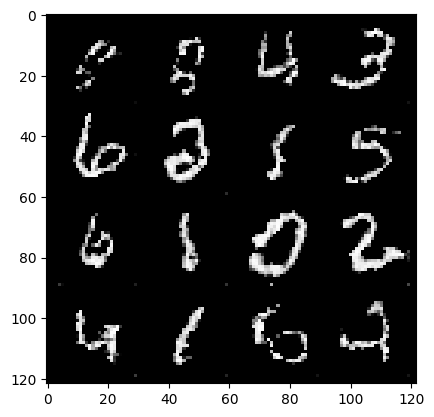

In [ ]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya